To obtain all the counterterms that emerge at each order in the perturbation expansion.

The different counterterm diagrams at each order will be of the form.

As the order increases the number of  

For example:
- 2nd order we would only have the counterterm 1-o-1.
- 3rd order we would have the counterterms 1-o-2 and 2-o-1.
- 4th order we would have: 1-o-1, 1-o-3, 3-o-1, 2-o-2.
- 5th order: 1-o-2, 2-o-1, 1-o-4, 4-o-1, 2-o-3, 3-o-2.
- 6th order: 1-o-1, 1-o-3, 3-o-1, 2-o-2, 1-o-5, 5-o-1, 2-o-4, 4-o-2, 3-o-3.
and so on.

So at each order we would have diagrams with the same appearance as the previous order of the same parity plus other diagrams which the sum of the number of incomming and outgoing particles equal the order considered.

Rememeber that in a perturbative expansion up till a certain order, we need to compute also the lower orders. Then we will need all the counterterms until that order.

For a certain theory, since the counterterms are the same for all interactions, we are interested in saving the counterterms in a file to be accessed in a latter calculation.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl



#From Chatgpt
def prune_points_and_reindex(points: np.ndarray,
                              paths: np.ndarray
                             ) -> tuple[np.ndarray, np.ndarray]:
    """
    Remove all [0,0] rows from `points`, then rebuild `paths` so that:
      - any path entry pointing to a removed point becomes 0,
      - all other entries are remapped down to a compact 1-based range.
    
    Parameters
    ----------
    points : np.ndarray, shape (N,2)
        Your (x,y) coordinates, with placeholder rows exactly equal to [0,0].
    paths : np.ndarray, shape (T,P,2), dtype=int
        Your 1-based index pairs, with [0,0] as placeholders.
    
    Returns
    -------
    new_points : np.ndarray, shape (M,2)
        The pruned points (no [0,0] rows).
    new_paths  : np.ndarray, shape (T,P,2)
        The updated paths, still 1-based with [0,0] placeholders.
    """
    # 1) Mask of rows to keep
    keep = ~(np.all(points == 0, axis=1))
    new_points = points[keep]
    
    # 2) Build old→new 1-based map
    #    new_idx[i] = new 1-based index of old row i, or 0 if dropped
    new_idx = np.zeros(points.shape[0], dtype=int)
    new_idx[keep] = np.arange(1, keep.sum()+1)
    
    # 3) Apply to paths
    #    For each entry u in paths: if u>0, replace with new_idx[u-1], else keep 0
    T, P, _ = paths.shape
    flat = paths.reshape(-1,2)
    # map both columns at once:
    mapped = np.zeros_like(flat)
    for col in (0,1):
        # grab the column, subtract 1 for 0-based indexing into new_idx
        o = flat[:,col]
        # for non-zero entries, look up new index; zeros stay zero
        mapped[:,col] = np.where(o>0, new_idx[o-1], 0)
    new_paths = mapped.reshape(T, P, 2)
    
    return new_points, new_paths

def represent_diagram (points, all_paths, index = False, directory = "", colors = ["tab:blue", "tab:red", "black"], line = ["solid", "solid", "photon"], count = 0):
    """
    Represent a diagram with points and paths.
    Args:
        points (np.array): array of points of dimension (n, 2)
        all_paths (list): list of paths to represent
        index (bool): whether to show the index of each point
        directory (str): directory to save the diagram
        colors (list): list of colors for each path
        line (list): list of line styles for each path
    """
    if (np.all(all_paths == 0)):
        return 
    
    points, all_paths = prune_points_and_reindex(points, all_paths)

    points = trim_zeros_2D(points)
    all_paths = trim_zeros_3D(all_paths, axis=1)
    
    fig=plt.figure(figsize=(5,3)) 
    ax=fig.add_subplot(111)
    ax.axis('off')
    j = 0

    # Note the that here the paths are more similar to the 1 particle case, meaning that is a 2D array
    for paths in all_paths:
        loops = find_equal_subarrays(paths)
        # Following the point made previously len(paths) indicate the number of connections instead of number of types of particles.
        for i in range(len(paths)):
            # In the case that the type of particle is a photon a spetial type of line is used to represent it.
            if (line[j] == "photon"):
                with mpl.rc_context({'path.sketch': (3, 15, 1)}):
                    if np.isin(i, loops):
                        middle_point = (points[paths[i, 0]-1] + points[paths[i, 1]-1]) / 2
                        circle = plt.Circle((middle_point[0], middle_point[1]), np.linalg.norm(points[paths[i, 0]-1]-middle_point), color=colors[j], fill=False)
                        ax.add_patch(circle)
                    elif paths[i, 0] == paths[i, 1] and paths[i ,0] != 0:
                        ax.scatter(points[paths[i, 0]-1, 0], points[paths[i, 0]-1, 1], color = colors[j])
                    else:
                        ax.plot([points[paths[i, 0]-1, 0], points[paths[i, 1]-1, 0]], [points[paths[i, 0]-1, 1], points[paths[i, 1]-1, 1]], color=colors[j])
            else:
                if np.isin(i, loops):
                    middle_point = (points[paths[i, 0]-1] + points[paths[i, 1]-1]) / 2
                    circle = plt.Circle((middle_point[0], middle_point[1]), np.linalg.norm(points[paths[i, 0]-1]-middle_point), color=colors[j], fill=False, linestyle=line[j])
                    ax.add_patch(circle)
                elif paths[i, 0] == paths[i, 1] and paths[i ,0] != 0:
                    ax.scatter(points[paths[i, 0]-1, 0], points[paths[i, 0]-1, 1], color = colors[j], s = 50, zorder = 10)
                else:
                    ax.plot([points[paths[i, 0]-1, 0], points[paths[i, 1]-1, 0]], [points[paths[i, 0]-1, 1], points[paths[i, 1]-1, 1]], color=colors[j], linestyle=line[j])
        j+=1
    ax.axis('equal')
    if index:
        for i in range(len(points)):
            ax.text(points[i, 0], points[i, 1], str(i+1), fontsize=12, color="black", ha="right", va="top")
    if count !=0:
        ax.text(0.5, 0.5, f"N = {count}", fontsize=12, color="black", ha="center", va="center")
    if directory != "":
        plt.savefig(directory, bbox_inches='tight')
        plt.close() #Added to not show in the notebook 

[[1, 1], [2, 1], [3, 1]]
[[1, 2], [2, 2], [2, 3]]
Order 2:
Order 3:
Order 4:
Order 5:
Order 6:
Order 7:


C:\Users\liuge\AppData\Local\Temp\ipykernel_11040\194920694.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(5,3))


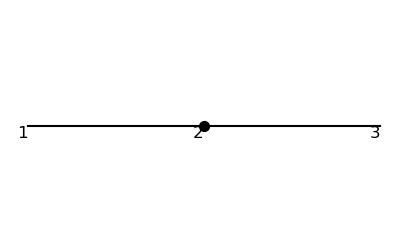

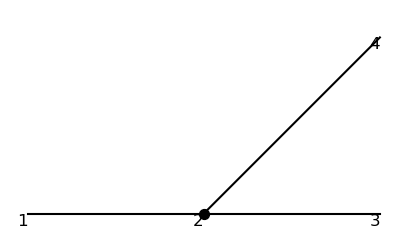

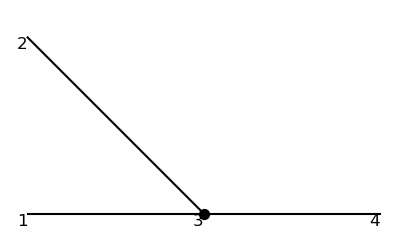

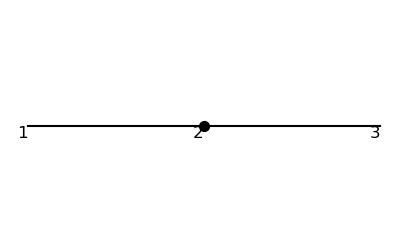

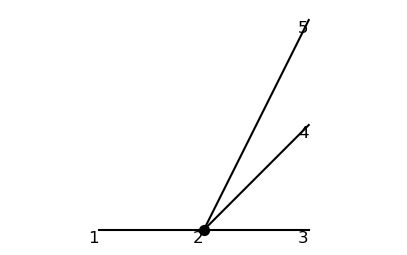

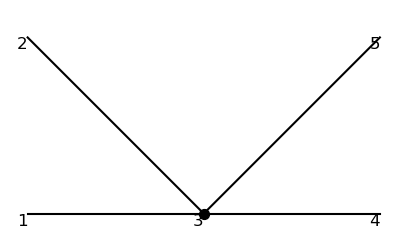

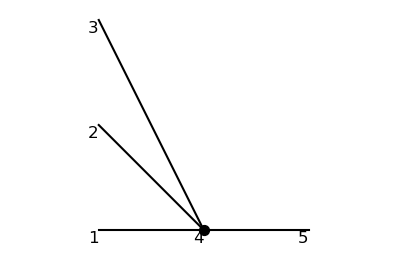

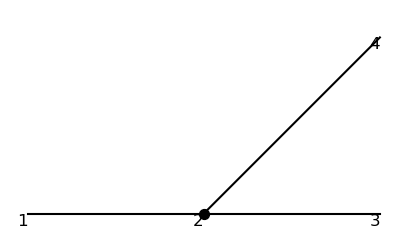

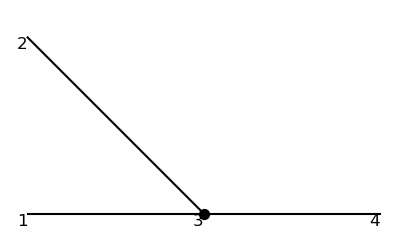

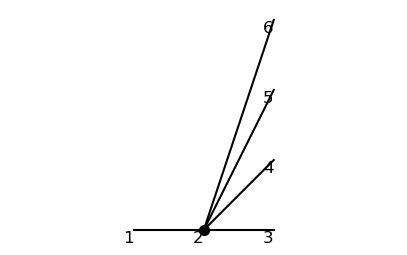

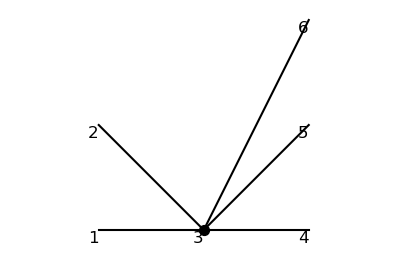

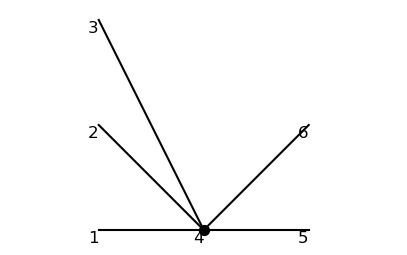

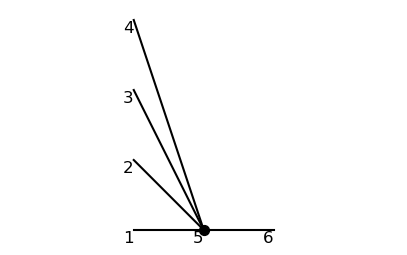

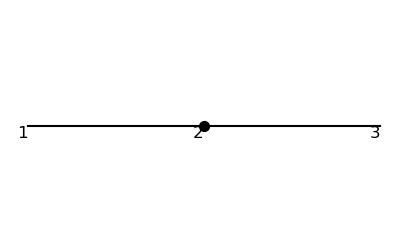

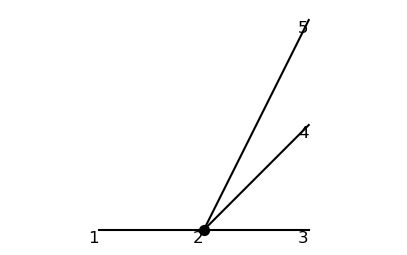

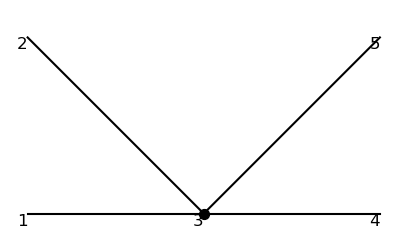

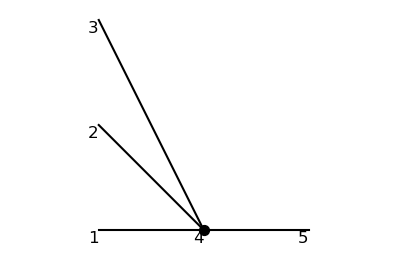

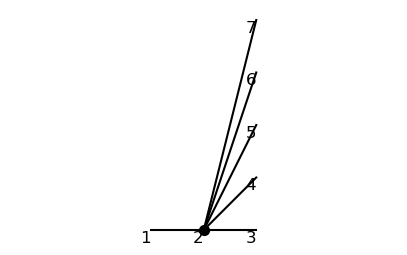

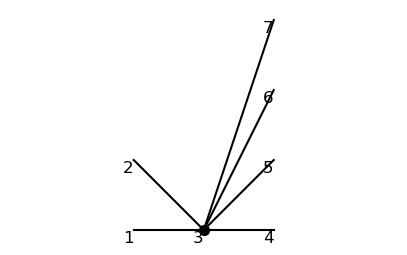

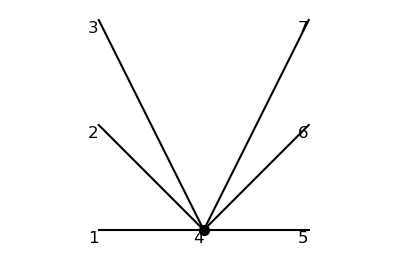

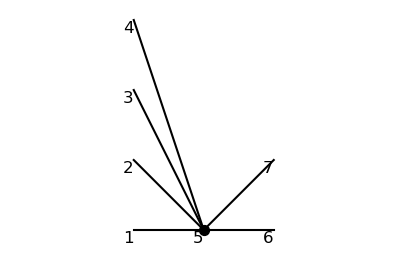

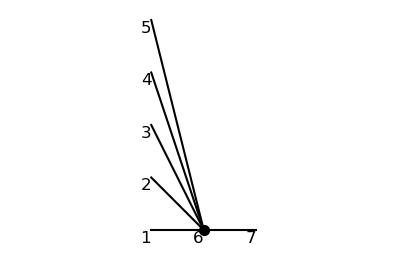

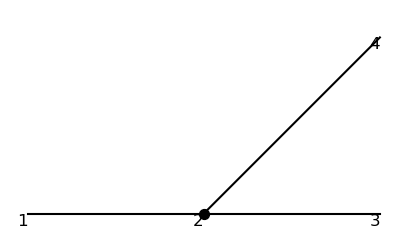

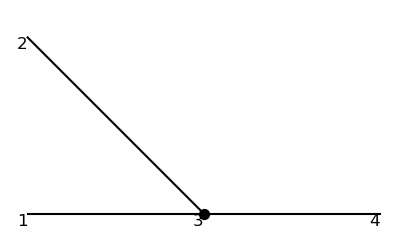

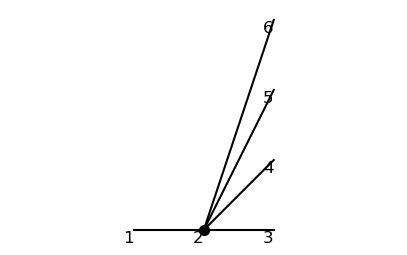

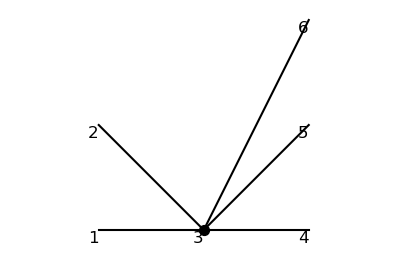

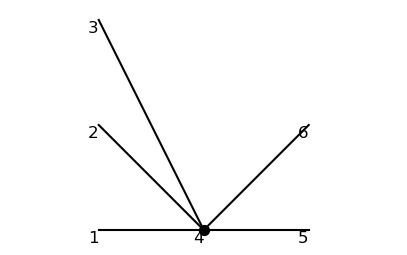

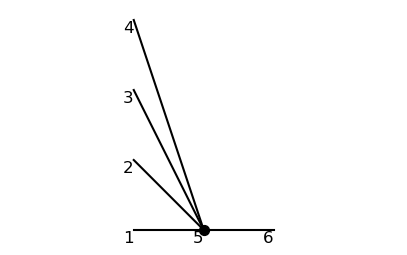

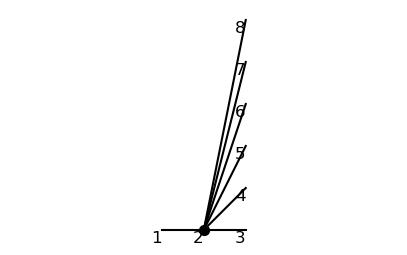

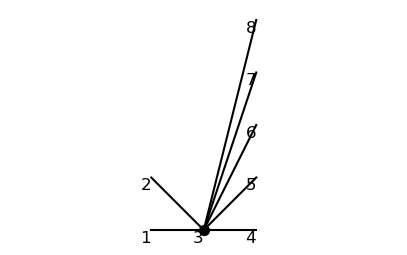

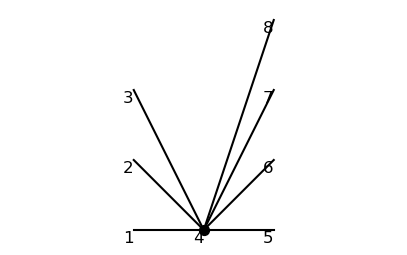

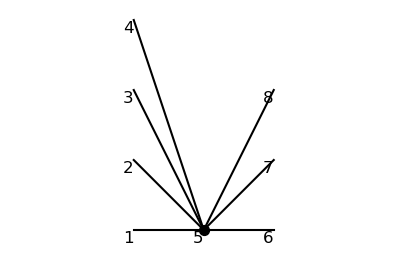

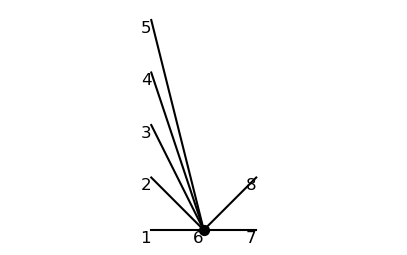

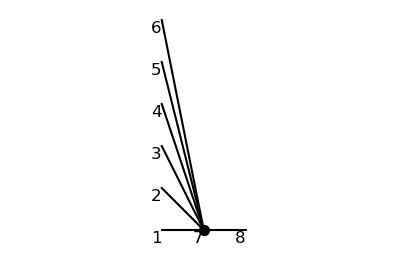

In [46]:
def return_counterterm_diagrams (order):
    """
    
    """
    #initialize the list of points and paths where the diagrams will be stored, and returned at the end.
    all_points = []
    all_paths = []
    #iterate through the order in perturbation (variable i)
    for i in range(2, order + 1):
        #initialize the list of points and paths for this order
        points_orders = []
        paths_orders = []
        #at each order, compute the counterterm diagrams
        #where j is the number of outgoing particles

        if (i > 3):
            if (i%2 == 0):
                j = i-4
                for l in range(len(all_points[j])):
                    points_orders.append(all_points[j][l])
                for l in range(len(all_paths[j])):
                    paths_orders.append(all_paths[j][l])

            if (i%2 == 1):
                j = i-4
                for l in range(len(all_points[j])):
                    points_orders.append(all_points[j][l])
                for l in range(len(all_paths[j])):
                    paths_orders.append(all_paths[j][l])

        for j in range(1, i):
            """
            Starting with the points for the diagrams.
            """
            #initialize a dummy array variable for each diagram
            points = []
            #k is the number of incoming particles
            k = i - j
            #create the outgoing points for the diagram
            for l in range(1, j+1):
                points.append([1, l])
            #create the point where the counterterm is located
            points.append([2, 1])
            #create the incoming points for the diagram
            for l in range(1, k+1):
                points.append([3, l])
            #append the points for this diagram
            points_orders.append(points)

            """
            Following a similar procedure for the paths.
            """
            #initialize a dummy array variable for each path
            paths = []
            for l in range(1, j+1):
                #create the outgoing paths for the diagram
                paths.append([l, j+1])
            paths.append([j+1, j+1])
            for l in range(1, k+1):
                #create the incoming paths for the diagram
                paths.append([j+1, j+l+1])
            #append the paths for this diagram
            paths_orders.append(paths)
            
        #append the points for this order
        all_points.append(points_orders)

        #append the paths for this order
        all_paths.append(paths_orders)
    
    return all_points, all_paths

n=7

print(return_counterterm_diagrams(n)[0][0][0])
print(return_counterterm_diagrams(n)[1][0][0])
for i in range(len(return_counterterm_diagrams(n)[0])):
    print(f"Order {i+2}:")
    for j in range(len(return_counterterm_diagrams(n)[0][i])):
        represent_diagram(np.array(return_counterterm_diagrams(n)[0][i][j]), np.array([return_counterterm_diagrams(n)[1][i][j],np.zeros_like(return_counterterm_diagrams(n)[1][i][j])]), index = True, colors=["black", "black"])
    

